In [49]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
pd.options.display.max_rows = 4000
import numpy as np

In [50]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [51]:
ylabel_name = 'marions_ylabels_esd_removed'
data_features = pd.read_csv("data/optimal_features.csv")

clustering_features = plotting.extract_numerical_features(data_features)

In [52]:

# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'Outlier':-1, 'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data

# Plot Labeled Data Only

In [53]:
plotting.plot_pca(marions_labeled_data, 
                  marions_labeled_data[f'{ylabel_name}_nums'], 
                  3, 
                  graph_title=f'',
                  ylabel_name=ylabel_name,)

# Random Forest Classifier

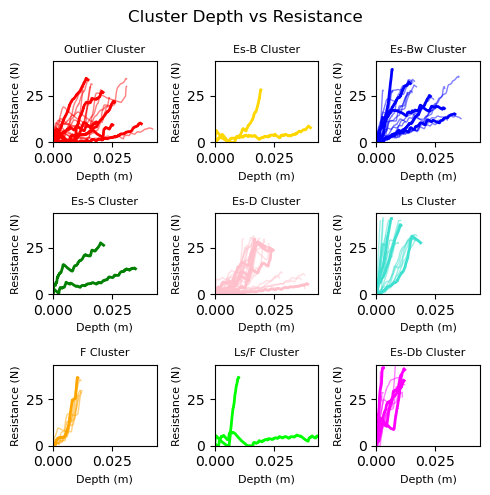

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
X = plotting.extract_numerical_features(marions_labeled_data).to_numpy()
y = marions_labeled_data[f'{ylabel_name}_nums']
rf_clf.fit(X, y)
rf_clf_y_pred = pd.Series(rf_clf.predict(clustering_features.values))

plotting.plot_cluster_subplots(rf_clf_y_pred, curve_data, 
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=marions_labeled_data.index
                                  )


# Used for Correcting Labels

In [55]:
def find_changed_ylabel_data(pseudo_labels:pd.Series, actual_labels:pd.Series):
    pseudo_actual_intersection = pseudo_labels.loc[actual_labels.index]
    diff_mask = pseudo_actual_intersection != actual_labels
    diff_labels = pseudo_actual_intersection[diff_mask]
    return diff_labels.index

def correct_pseudo_ylabels_to_actual(pseudo_labels:pd.Series, actual_labels:pd.Series, changed_ylabel_idxs) -> pd.Series:
    corrected_pseudo_labels = pseudo_labels.copy()
    corrected_pseudo_labels.loc[changed_ylabel_idxs] = actual_labels
    return corrected_pseudo_labels

# Nearest Centroid
- Each class is represented by it's centroid, with test sample classified to the class with the nearest centroid

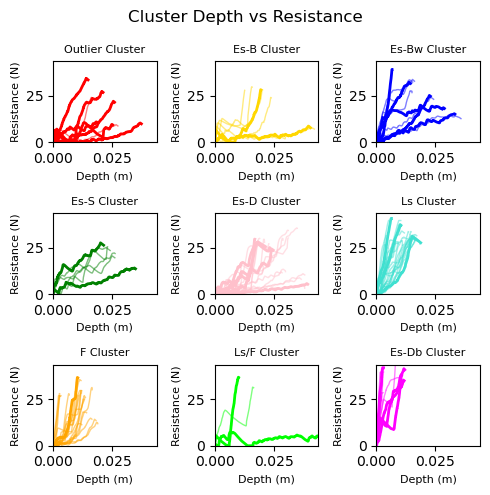

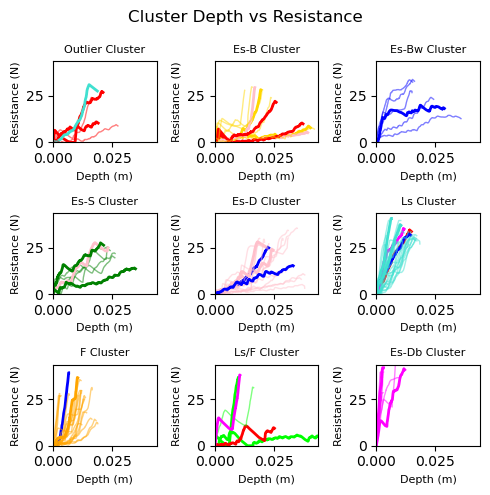

In [56]:
from sklearn.neighbors import NearestCentroid

X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()
nc = NearestCentroid()
nc.fit(X,y)
nc_predictions = pd.Series(nc.predict(clustering_features.values))

nc_actual = marions_labeled_data[f'{ylabel_name}_nums']
nc_changed_ylabel_idxs = find_changed_ylabel_data(nc_predictions, nc_actual)
nc_corrected_predictions = correct_pseudo_ylabels_to_actual(nc_predictions, nc_actual, nc_changed_ylabel_idxs)

plotting.plot_cluster_subplots(nc_corrected_predictions, curve_data, 
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=nc_actual.index
                                  )
plotting.plot_cluster_subplots(nc_predictions, curve_data,
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  pseudo_corrections=nc_corrected_predictions,
                                  bold_idxs=nc_actual.index
                                  )
plotting.plot_pca(clustering_features, nc_predictions, 3,
                  graph_title=f'',
                  ylabel_name=ylabel_name,)

# Iterative Nearest Centroid

[[0.   0.   0.   0.   0.   0.02 0.97 0.   0.  ]
 [0.   0.   0.45 0.   0.   0.53 0.   0.   0.01]
 [0.   0.   0.   0.   0.   0.07 0.05 0.   0.88]
 [0.   0.   0.05 0.   0.95 0.   0.   0.   0.  ]
 [0.02 0.   0.02 0.   0.   0.49 0.45 0.   0.02]
 [0.01 0.   0.05 0.   0.94 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
 [0.2  0.   0.03 0.56 0.2  0.   0.   0.   0.  ]
 [0.   0.   0.63 0.   0.01 0.34 0.02 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.22 0.   0.   0.77]
 [0.   0.   0.08 0.   0.   0.8  0.   0.   0.12]
 [0.15 0.19 0.01 0.   0.01 0.   0.01 0.62 0.  ]
 [0.   0.   0.   0.   0.   0.   0.99 0.   0.  ]
 [0.01 0.   0.12 0.   0.6  0.01 0.26 0.   0.  ]
 [0.   0.   0.   0.   0.   0.4  0.05 0.   0.55]
 [0.   0.   0.46 0.   0.   0.52 0.   0.   0.01]
 [0.   0.   0.   0.   0.   0.04 0.96 0.   0.01]
 [0.01 0.   0.03 0.97 0.   0.   0.   0.   0.  ]
 [0.01 0.   0.07 0.01 0.86 0.   0.04 0.   0.  ]
 [0.01 0.   0.   0.   0.01 0.   0.98 0. 

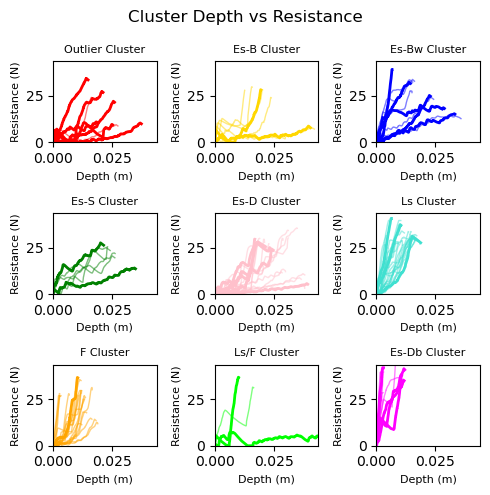

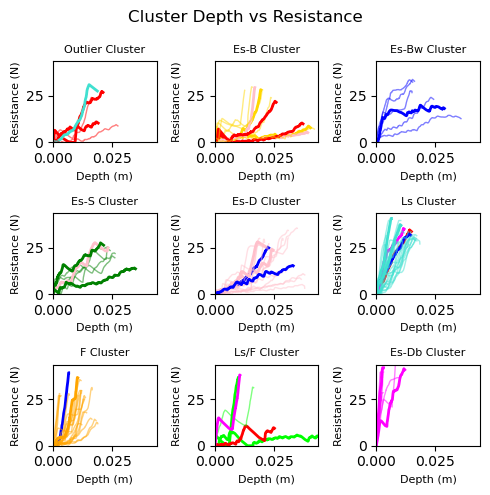

In [ ]:
from sklearn.neighbors import NearestCentroid

X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()
nc = NearestCentroid()
nc.fit(X,y)
nc_predictions = pd.Series(nc.predict(clustering_features.values))
np_prediction_prob = np.round(nc.predict_proba(clustering_features.values), 2)
print(np_prediction_prob)

"""
1. fit x y
2. predict
3. add points with very high prob to labeled data 
continuously iterate until ____4____

implementation of part 2 - im not sure which is better
    1. out of all predicted, add highest prob psuedo label to it's respective class
    2. add all prediction probs above threshold to their respective class * 
implementation of part 4
    1. when no prob confidence exists above threshold, make pseudo predictions *
    2. when no probs condience exists above threshold, lower threshold X
"""

def nearest_centroid_iterations(marions_labeled_data:pd.DataFrame, clustering_features:pd.DataFrame, prob_threshold:float) -> pd.Series:
    labeled_data = marions_labeled_data.copy()
    unlabeled_data = clustering_features.copy()
    high_prediction_idxs = [-1]

    while len(high_prediction_idxs):
        nc = NearestCentroid()
        X = plotting.extract_numerical_features(labeled_data).values.tolist()
        y = labeled_data[f'{ylabel_name}_nums'].values.tolist()
        nc.fit(X,y)
        unlabeled_data = clustering_features.drop(labeled_data.index, axis=0).values
        np_predictions = nc.predict(unlabeled_data)
        np_prediction_probs = np.round(nc.predict_proba(unlabeled_data), 2)

        high_prediction_idxs = np.where(np.any(np_prediction_probs > prob_threshold, axis=1))[0]
        high_prediction_unlabeled_data = unlabeled_data.loc[high_prediction_idxs, :]
        high_prediction_unlabeled_data[f'{ylabel_name}_nums'] = np_predictions
        
        if len(high_prediction_idxs):
            pd.concat([labeled_data, high_prediction_unlabeled_data], axis=0)
    
    return pd.concat([labeled_data, high_prediction_unlabeled_data], axis=0)

nc_actual = marions_labeled_data[f'{ylabel_name}_nums']
nc_changed_ylabel_idxs = find_changed_ylabel_data(nc_predictions, nc_actual)
nc_corrected_predictions = correct_pseudo_ylabels_to_actual(nc_predictions, nc_actual, nc_changed_ylabel_idxs)

plotting.plot_cluster_subplots(nc_corrected_predictions, curve_data, 
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=nc_actual.index
                                  )
plotting.plot_cluster_subplots(nc_predictions, curve_data,
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  pseudo_corrections=nc_corrected_predictions,
                                  bold_idxs=nc_actual.index
                                  )
plotting.plot_pca(clustering_features, nc_predictions, 3,
                  graph_title=f'',
                  ylabel_name=ylabel_name,)

# K-Nearest-Neighbor
- From the k nearest points, assign query point to the highest frequency label
- Performs better when data is uniformly distributed in feature space (clusters all have similar desnity)

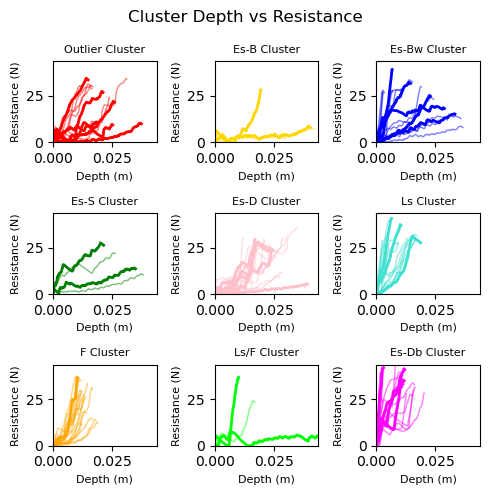

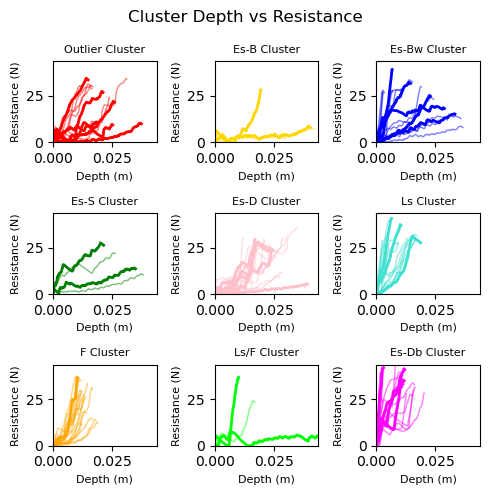

In [58]:
from sklearn.neighbors import KNeighborsClassifier

X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
knn_predictions = pd.Series(knn.predict(clustering_features.values))
knn_actual = marions_labeled_data[f'{ylabel_name}_nums']
knn_changed_ylabel_idxs = find_changed_ylabel_data(knn_predictions, knn_actual)
knn_corrected_predictions = correct_pseudo_ylabels_to_actual(knn_predictions, knn_actual, knn_changed_ylabel_idxs)

plotting.plot_cluster_subplots(knn_predictions, curve_data,
                                  clustering_method="K-Nearest Neighbor", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  pseudo_corrections=knn_corrected_predictions,
                                  bold_idxs=knn_actual.index
                                  )
plotting.plot_cluster_subplots(knn_corrected_predictions, curve_data, 
                                  clustering_method="K-Nearest Neighbor", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=knn_actual.index)
plotting.plot_pca(clustering_features, knn_predictions, 3, 
                  graph_title=f'',
                  ylabel_name=ylabel_name,)

# Radius Neighbors Classifier
- Within radius r, assing query point to highest frequency label
- Good for when data isn't uniformly distributed (clusters have different densities)

/home/frankwoods/anaconda3/envs/env3.13/lib/python3.13/site-packages/sklearn/neighbors/_classification.py:864: UserWarning:

Outlier label -1 is not in training classes. All class probabilities of outliers will be assigned with 0.



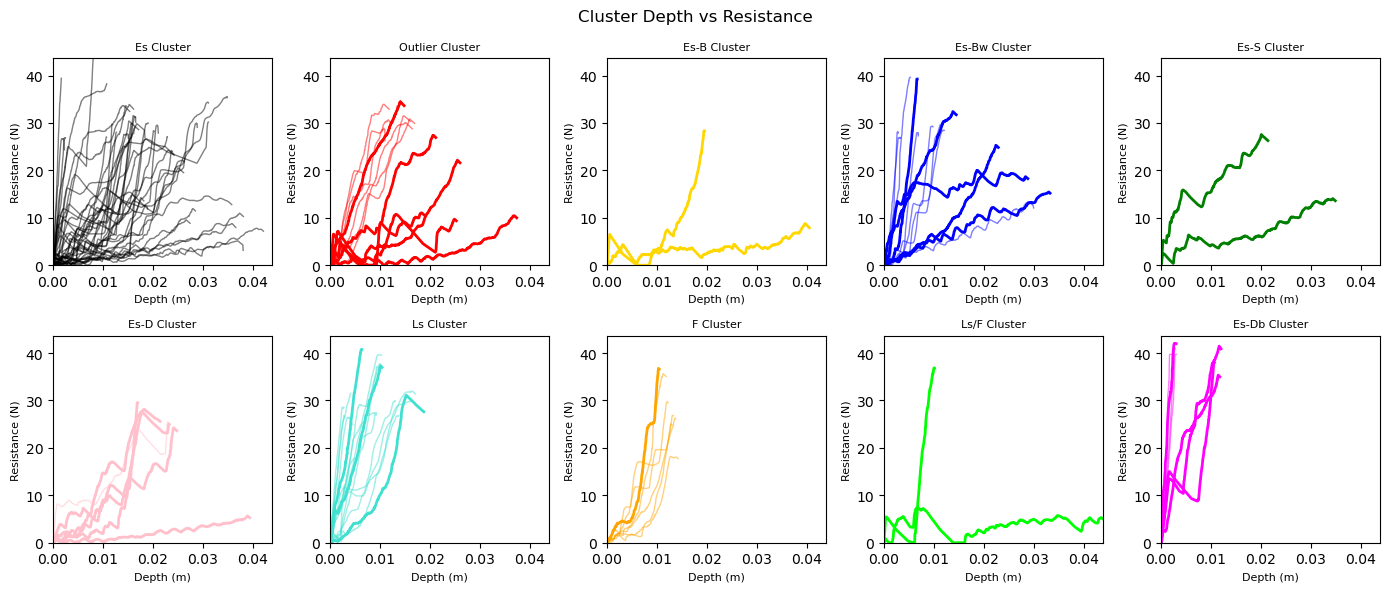

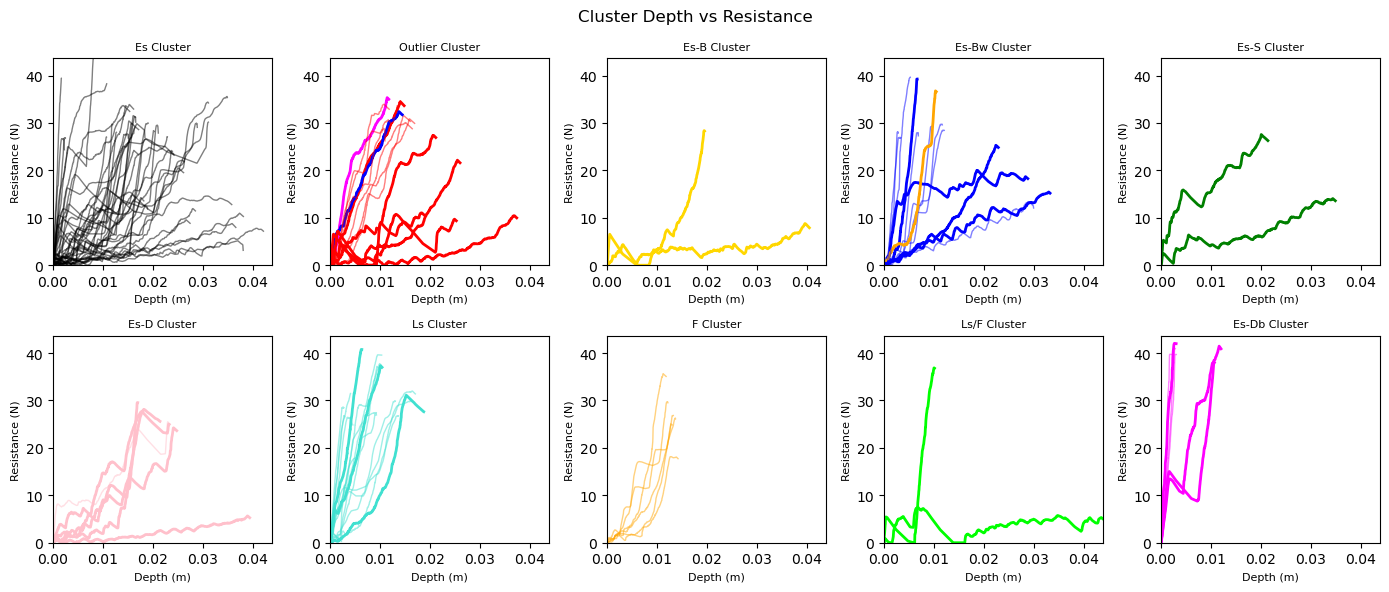

In [59]:
from sklearn.neighbors import RadiusNeighborsClassifier


X = plotting.extract_numerical_features(marions_labeled_data).values.tolist()
y = marions_labeled_data[f'{ylabel_name}_nums'].values.tolist()
rn = RadiusNeighborsClassifier(radius=1.5, outlier_label=-1)
rn.fit(X,y)
rn_predictions = pd.Series(rn.predict(clustering_features.values))

rn_actual = marions_labeled_data[f'{ylabel_name}_nums']
rn_changed_ylabel_idxs = find_changed_ylabel_data(rn_predictions, rn_actual)
rn_corrected_predictions = correct_pseudo_ylabels_to_actual(rn_predictions, rn_actual, rn_changed_ylabel_idxs)

plotting.plot_cluster_subplots(rn_corrected_predictions, curve_data, 
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=rn_actual.index
                                  )
plotting.plot_cluster_subplots(rn_predictions, curve_data,
                                  clustering_method="Nearest Centroid", 
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  pseudo_corrections=rn_corrected_predictions,
                                  bold_idxs=rn_actual.index
                                  )
plotting.plot_pca(clustering_features, rn_predictions, 3, 
                  graph_title=f'',
                  ylabel_name=ylabel_name,)